In this assignment the goal is to implement the dimensionality reduction technique *Principal Component Analysis (PCA)* to a very high dimensional data and apply visualization. Note that you are not allowed to use the built-in PCA API provided by the sklearn library. Instead you will be implementing from the scratch.

For this task we use the MNIST dataset. First we download the dataset using openml api

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)
X = mnist.data
y = mnist.target

print(X.shape, y.shape)
print(y)

(70000, 784) (70000,)
['5' '0' '4' ... '4' '5' '6']


# Part-1: Preprocessing
Before implementing PCA you are required to perform some preprocessing steps:
* Mean normalization: Replace each feature/attribute, $x_{ji}$ with $x_j - \mu_j$, In other words, determine the mean of each feature set, and then for each feature subtract the mean from the value, so we re-scale the mean to be 0 
* Feature scaling: If features have very different scales then scale make them comparable by altering the scale, so they all have a comparable range of values e.g. $x_{ji}$ is set to $(x_j - \mu_j) / s_j$  Where $s_j$ is some measure of the range, so could be  $\max(x_j) - \min(x_j)$ or Standard deviation $stddev(x_j)$.

In [2]:
(X.std(axis=0) == 0).sum()

65

First of all, we observe that some features have a standard deviation equal to zero. These features have no discriminative power because all values are equal to the mean, so we can remove them from the analysis. This also allow us to divide by the standard deviation without worrying about division by zero when normalizing the dataset.

In [3]:
X_filtered = X[:, (X.std(axis=0) != 0)]
X_filtered.shape

(70000, 719)

Now that we removed the 65 unsignificant features, we can normalize our dataset.

In [4]:
X_normalized = (X_filtered - X_filtered.mean(axis=0)) / X_filtered.std(axis=0)

# Part-2: Covariance matrix
Now the preprocessing is finished. Next, as explained in the lecture, you need to compute the covariance matrix https://en.wikipedia.org/wiki/Covariance_matrix. Given $n \times m$ $n$ rows and $m$ columns matrix, a covariance matrix is an $n \times n$ matrix given as below (sigma)
$\Sigma = \frac{1}{m}\sum{\left(x^{i}\right)\times \left(x^{i}\right)^{T}}$
You may use the "numpy.cov" function in numpy library 

In [5]:
sigma = np.cov(X_normalized, rowvar=False)
sigma.shape

(719, 719)

# Part-3: SVD computation
Now compute the SVD on the covariance matrix $SVD(\Sigma)$. You may use the svd implementation in numpy.linalg.svd

In [6]:
def getSVD(cov_matrix):
    return np.linalg.svd(cov_matrix,  full_matrices=False)

In [7]:
U, S, V = getSVD(sigma)

# Part-4: Compute PCA matrix (K dimensional)
Now select the first $k$ columns from the matrix $U$ and multiply with $X$ to get $k$ dimensional representation.

In [8]:
def getKComponents(U, X, K):
    return (U[:, :K].T @ X.T).T

In [9]:
Z = getKComponents(U, X_normalized, X_normalized.shape[0])

# Part-5: Compute Reconstruction Error
Implement a function to compute the variance ratio (from reconstruction error)

In [10]:
def getVarianceRatio(PCA, U, X, K):
    X_reconstructed = U[:, :K] @ PCA[:, :K].T
    return np.linalg.norm(X_reconstructed.T-X)**2 / np.linalg.norm(X)**2

Compare the variance ratio to the built-in PCA implementation in sklearn.

In [11]:
from sklearn.decomposition import PCA
model = PCA(n_components=42)
Z_sklearn = model.fit_transform(X_normalized)
X_sklearn = model.inverse_transform(Z_sklearn)
variance_ratio_sklearn = np.linalg.norm(X_sklearn-X_normalized)**2 / np.linalg.norm(X_normalized)**2

In [12]:
print(f'{getVarianceRatio(Z, U, X_normalized, 42):.5f} ~= {variance_ratio_sklearn:.5f}')

0.48542 ~= 0.48564


# Part-6: Scatter plot 2-dimensional PCA
Using matplotlib plot the 2-dimensional scatter plot of the first 2 compoenents with y (target) as labels

In [13]:
from matplotlib import pyplot as plt
N_DISPLAYED = 10000
colors = {
    '0':'red',
    '1':'green',
    '2':'blue',
    '3':'yellow',
    '4':'cyan',
    '5':'magenta',
    '6':'yellow',
    '7':'olive',
    '8':'black',
    '9':'orange',
}

Z_2 = getKComponents(U, X_normalized, 2)
mapping = [colors[_] for _ in y[:N_DISPLAYED]]
plt.scatter(Z_2[:N_DISPLAYED, 0], Z_2[:N_DISPLAYED, 1], c=mapping)

We obtain the same visualization with sklearn's library.

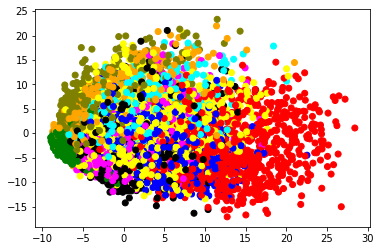

In [14]:
Z_sklearn = PCA(n_components=2).fit_transform(X_normalized)
plt.scatter(Z_sklearn[:N_DISPLAYED, 0], Z_sklearn[:N_DISPLAYED, 1], c=mapping)

# Part-7 Find best $K$
Find the minimum value of $K$ with which the ratio between averaged squared projection error with total variation in data is less than 10% in other words we retain 90% of the variance. You can achieve this by repeating getKComponents with $K=1$ until the variance ratio is <= 10%.

In [15]:
def optimal_k():
    test_k = 1
    ratio = getVarianceRatio(Z, U, X_normalized, test_k)
    while ratio >= 0.1:
        test_k += 1
        ratio = getVarianceRatio(Z, U, X_normalized, test_k)
    print(f'optimal K = {test_k}, variance ratio = {ratio}')
    return test_k

In [16]:
k_opt = optimal_k()

optimal K = 238, variance ratio = 0.09954823526394403


# Part-8: TSNE visualization
Finally, having found an optimal $K$ use these components as an input data to another dimensionality reduction method called tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) and reduce it to 2 dimensions.

In [17]:
from sklearn.manifold import TSNE
n_sne = 10000 # it is sufficient if done for 10k samples
rndperm = np.random.permutation(X_normalized.shape[0])[:n_sne]
pca_result = getKComponents(U, X_normalized, k_opt)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result[rndperm])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.061s...
[t-SNE] Computed neighbors for 10000 samples in 32.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.009508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.739494
[t-SNE] KL divergence after 300 iterations: 2.801995


Finally, scatter plot the components given by the tSNE using matplotlib compare it to the earlier scatter plot.

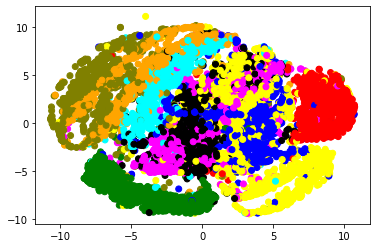

In [18]:
mapping = [colors[_] for _ in y[rndperm]]
plt.scatter(tsne_pca_results[:, 0], tsne_pca_results[:, 1], c=mapping)